importing the modules required for neural network

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

libraries added to implement bayesian optimization

In [3]:
import warnings
from bayes_opt.constraint import ConstraintModel
from bayes_opt import BayesianOptimization, UtilityFunction, util
# from .target_space import TargetSpace
# from .event import Events, DEFAULT_EVENTS
# from .logger import _get_default_logger
# from .util import UtilityFunction, acq_max, ensure_rng
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import roc_auc_score

importing the dataset

In [4]:
df = pd.read_csv("ercot-dataset.csv", sep=',')
# to change the float to two decimal places following code is used
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df = df.iloc[:80000]
print(df)

                   Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  \
0         1/1/2006 0:30    23.90   21.65    22.40     87.50      19.67    1   
1         1/1/2006 1:00    23.90   21.70    22.40     88.00      18.56    1   
2         1/1/2006 1:30    23.80   21.65    22.35     88.00      19.09    1   
3         1/1/2006 2:00    23.70   21.60    22.30     88.00      17.40    1   
4         1/1/2006 2:30    23.70   21.60    22.30     88.00      17.00    1   
...                 ...      ...     ...      ...       ...        ...  ...   
87643  31/12/2010 22:00    22.60   19.10    20.40     81.00      23.86   31   
87644  31/12/2010 22:30    22.45   19.05    20.30     81.50      26.49   31   
87645  31/12/2010 23:00    22.30   19.00    20.20     82.00      25.18   31   
87646  31/12/2010 23:30    22.05   19.05    20.15     83.50      26.19   31   
87647     1/1/2011 0:00    21.80   19.10    20.10     85.00      24.62    1   

       Month  Year  Minutes  SYSLoad  
0          1

In [21]:
# prints the high level information about the data
'''df.info()'''

'df.info()'

In [22]:
# gives additional statistical information
'''df.describe()'''

'df.describe()'

In [5]:
# to check the total missing data on each features
# zero indicates there is no missing data values
df.isnull().sum()
#df1 = df.drop(['Date','Month','Year', 'Day','Minutes'], axis=1)
df1 = df.drop(['Date','Year'], axis=1)

In [24]:
# df1.corr()
# # to see the correlation between features
# # this helps to see how one parameters has effects on others
# # lets see the plot of correlation data
# sns.heatmap(df1.corr(), annot= True)
# plt.rcParams["figure.figsize"]=(15,10)
# plt.title('Correlation Matrix', fontsize=16)
# plt.show()

In [6]:
# this will select all the rows and columns except the last one from df and assign to x variable
# df1 does not contain the date in the first column in string format
x = df1.iloc[:,:-1].values
#x = df1.iloc[:,1].values
# quality is taken target variable and it in last column and is assigned to y variable
y = df1.iloc[:,-1].values
# encoding the categorical data using onehotencoder this is for classification tasks
'''ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')
x = ct.fit_transform(x)
x = x.toarray() # converts encoded data to dense array (optional) would show error without this'''

"ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')\nx = ct.fit_transform(x)\nx = x.toarray() # converts encoded data to dense array (optional) would show error without this"

Splitting the dataset into the training and test set

In [7]:
from sklearn.model_selection import train_test_split
# we will split the data into training and testing data using following code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean deviation of train data: {x_train.mean()}')

feature standardization and conversion to tensor

In [8]:
# Feature Scaling (not necessary for neural networks, but can be applied)
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# print(f'Standard deviation of test data: {x_test.std()}')
# print(f'mean of test data: {x_test.mean()}')
# print(f'Standard deviation of train data: {x_train.std()}')
# print(f'mean of train data: {x_train.mean()}')
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# Create a PyTorch dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
len(x_train)
#len(test_loader)

70118

Deep Neural Network Model (3 hidden layers), forward pass and back propagation

In [34]:
from bayes_opt import BayesianOptimization
# Define the function to optimize
def train_model(lr, hidden_size1, hidden_size2, hidden_size3, num_epochs):
    # Define the neural network model
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size1)   # using linear activation function at the input
            #self.relu = nn.ReLU()   # activation function for hidden layer, Relu
            self.sigmoid = nn.Sigmoid()   # activation function for hidden layer, sigmoid
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)   # input layer to hidden layer
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.fc4 = nn.Linear(hidden_size3, 1)
            # self.fc4 = nn.Linear(32, 16)
            # self.fc5 = nn.Linear(16, 1) # hidden to output layer

        def forward(self, X):
            X = self.fc1(X) #input layer
            X = self.sigmoid(X)
            X = self.fc2(X) # hidden layer
            X = self.sigmoid(X)
            X = self.fc3(X) # hidden layer
            #X = self.sigmoid(X)
            X = self.fc4(X) # hidden layer
            # X = self.fc5(X) # output layer
            return X
    
    # Instantiate the model and define the loss function and optimizer
    input_size = x_train.shape[1]
    model = NeuralNetwork(input_size, int(hidden_size1), int(hidden_size2),int(hidden_size3))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    #num_epochs = 20

    train_losses = []
    val_losses = []
    test = 0
    for epoch in range(int(num_epochs)):
        model.train()
        for inputs, labels in train_loader:
            total_loss = 0.0
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(f'test output {len(outputs)}')
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # print(test)
            # test += 1
            #print(f'test total loss {temp.shape}')
            #print(f'Total loss Test {total_loss}')

        # Validation loss/ this is loss for test
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                val_loss = 0.0
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                #print(np.array(val_loss).astype(int))
                #print(f'outputs Test {outputs}, labels {labels} ')

        avg_train_loss = total_loss / len(x_train)
        avg_val_loss = val_loss / len(x_test)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    #print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)
        y_test_np = y_test_tensor.numpy()
        y_pred = y_pred_tensor.numpy()
        mse = mean_squared_error(y_test_np, y_pred)
    return -mse

# Define the search space for hyperparameters
pbounds = {'lr': (1e-5, 1e-1), 'hidden_size1': (8, 256), 'hidden_size2': (8, 128), 'hidden_size3': (8, 128), 'num_epochs':(10,100)}

# Initialize BayesianOptimization
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=200)

# Get the best hyperparameters
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_lr = best_params['lr']
best_hidden_size1 = best_params['hidden_size1']
best_hidden_size2 = best_params['hidden_size2']
best_hidden_size3 = best_params['hidden_size3']
best_num_epochs = best_params['num_epochs']

best_mse = train_model(best_lr, best_hidden_size1, best_hidden_size2, best_hidden_size3, best_num_epochs)
print("Best Mean Squared Error:", -best_mse)  # Convert back to positive MSE
#r2_score(y_test, y_pred)


|   iter    |  target   | hidden... | hidden... | hidden... |    lr     | num_ep... |
-------------------------------------------------------------------------------------
| 1         | -3.095e+0 | 100.9     | 122.1     | 95.84     | 0.05987   | 24.04     |
| 2         | -2.564e+0 | 46.69     | 14.97     | 111.9     | 0.06012   | 73.73     |
| 3         | -2.484e+0 | 13.1      | 124.4     | 107.9     | 0.02124   | 26.36     |
| 4         | -2.582e+0 | 53.48     | 44.51     | 70.97     | 0.0432    | 36.21     |
| 5         | -2.648e+0 | 159.7     | 24.74     | 43.06     | 0.03664   | 51.05     |
| 6         | -2.72e+05 | 22.02     | 123.9     | 108.5     | 0.07934   | 37.44     |
| 7         | -2.012e+0 | 232.8     | 20.64     | 25.67     | 0.09253   | 79.36     |
| 8         | -2.449e+0 | 51.58     | 50.57     | 70.76     | 0.04401   | 34.9      |
| 9         | -8.025e+0 | 136.2     | 8.0       | 128.0     | 1e-05     | 10.0      |
| 10        | -2.634e+0 | 163.6     | 24.35     | 46.3

In [60]:
def DeepNeuralNetwork (lr, hidden_size1, hidden_size2, hidden_size3, num_epochs):
    # Define the neural network model
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size1)   # using linear activation function at the input
            #self.relu = nn.ReLU()   # activation function for hidden layer, Relu
            self.sigmoid = nn.Sigmoid()   # activation function for hidden layer, sigmoid
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)   # input layer to hidden layer
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.fc4 = nn.Linear(hidden_size3, 1)
            # self.fc5 = nn.Linear(16, 1) # hidden to output layer

        def forward(self, X):
            X = self.fc1(X) #input layer
            X = self.sigmoid(X)
            X = self.fc2(X) # hidden layer
            X = self.sigmoid(X)
            X = self.fc3(X) # hidden layer
            #X = self.sigmoid(X)
            X = self.fc4(X) # hidden layer
            # X = self.fc5(X) # output layer
            return X
        
    # Instantiate the model and define the loss function and optimizer
    hidden_size1 = 132
    hidden_size2 = 86
    hidden_size3 = 39
    input_size = x_train.shape[1]
    model = NeuralNetwork(input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)

    # Train the model
    # num_epochs = 82

    train_losses = []
    val_losses = []
    test = 0
    for epoch in range(int(num_epochs)):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(f'test output {len(outputs)}')
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # print(test)
            # test += 1
            #print(f'test total loss {temp.shape}')
            #print(f'Total loss Test {total_loss}')

        # Validation loss/ this is loss for test
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                #print(np.array(val_loss).astype(int))
                #print(f'outputs Test {outputs}, labels {labels} ')

        avg_train_loss = total_loss / len(x_train)
        avg_val_loss = val_loss / len(x_test)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        #print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)

    # Convert predictions back to NumPy arrays
    y_pred = y_pred_tensor.numpy()
    y_test_np = y_test_tensor.numpy()

    # Evaluate the Model Performance
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    #print(f'y_test_np: {y_test_np}, y_pred: {y_pred}')
    #print(f'length y_test_np: {len(y_test_np)}')

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')

    # Plotting the learning curve
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # Plotting the results (optional)
    plt.scatter(y_test, y_pred, color='blue')
    plt.title('Neural Network')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()
    
    # plot of test and predicted value
    plt.plot(y_test_np[100:200], label='Test Value')
    plt.plot(y_pred[100:200],linestyle='--', linewidth = 1.2, label='Predicted Value')
    plt.legend()
    plt.title('Test Vs Predicted value')
    plt.xlabel('Actual/Predicted values')
    plt.ylabel('values')
    plt.show()

    r2_score(y_test, y_pred)

    return -mse

Mean Squared Error: 201110.03125
Mean Absolute Error: 343.7699279785156
R-squared: 0.9000218345564286


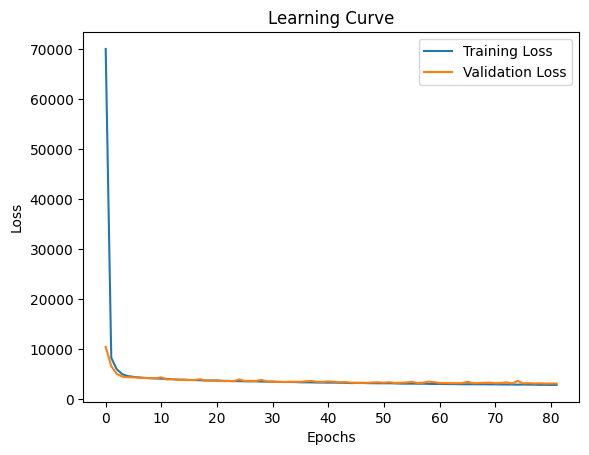

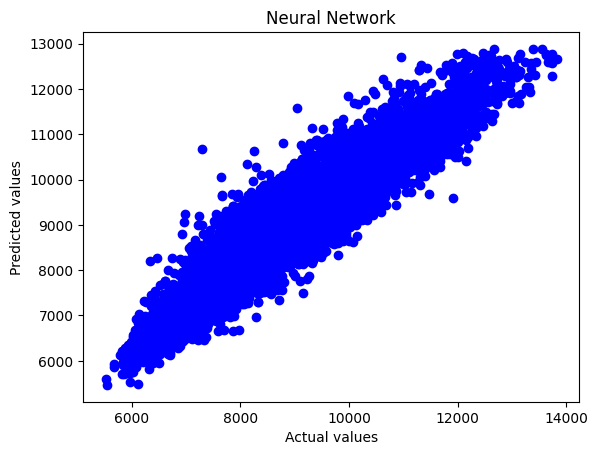

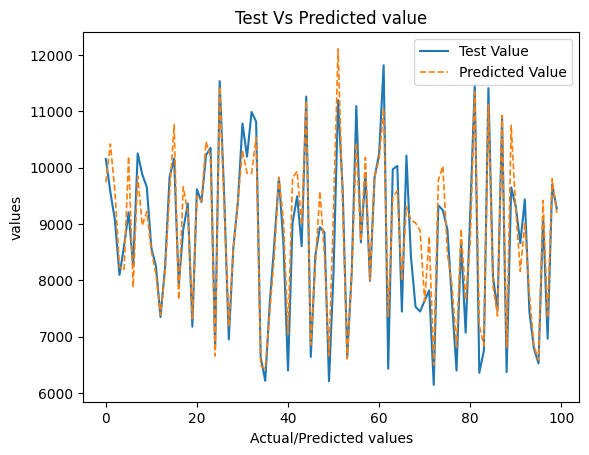

-201110.03

In [61]:
DeepNeuralNetwork(best_lr, int(best_hidden_size1), int(best_hidden_size2), int(best_hidden_size3), int(best_num_epochs))

lets implement random search optimization for Neural Network Algorithm

In [17]:
# # code starts from here for random search for NN
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import r2_score
# from sklearn.neural_network import MLPRegressor

# hidden_layer_sizes_range = [(i, j, k) for i in range(8, 64, 8) for j in range(8, 128, 128) for k in range(64, 8, 128)]
# # Define the hyperparameter grid
# param_grid = {
#     'learning_rate_init': [0.00001, 0.01],
#     'hidden_layer_sizes': hidden_layer_sizes_range,
#     'max_iter': [8, 20, 30, 100]
# }

# nn_model = MLPRegressor(random_state=42)
# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=nn_model, 
#                                    param_distributions=param_grid, 
#                                    n_iter=10, 
#                                    cv=5, 
#                                    scoring='neg_mean_squared_error',
#                                    random_state=42,
#                                    n_jobs=-1)

# # Perform the search
# random_search.fit(x_train, y_train)

# # Get the best parameters and best score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", -best_score)


# # class DeepNeuralNetwork:
# #     def __init__(self, lr=0.001, hidden_size1=100, hidden_size2=100, hidden_size3=100, num_epochs=100):
# #         self.lr = lr
# #         self.hidden_size1 = hidden_size1
# #         self.hidden_size2 = hidden_size2
# #         self.hidden_size3 = hidden_size3
# #         self.num_epochs = num_epochs
# #         self.model = MLPRegressor(hidden_layer_sizes=(hidden_size1, hidden_size2, hidden_size3),
# #                                   learning_rate_init=lr,
# #                                   max_iter=num_epochs,
# #                                   random_state=42)
    
# #     def fit(self, X, y):
# #         self.model.fit(X, y)
    
# #     def predict(self, X):
# #         return self.model.predict(X)

ValueError: Parameter grid for parameter 'hidden_layer_sizes' need to be a non-empty sequence, got: []

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

def DeepNeuralNetwork(x_train, y_train, x_test, y_test, num_epochs, lr, hidden_size1, hidden_size2, hidden_size3):
    # Define the neural network model
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size1)   # using linear activation function at the input
            self.sigmoid = nn.Sigmoid()   # activation function for hidden layer, sigmoid
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)   # input layer to hidden layer
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.fc4 = nn.Linear(hidden_size3, 1)

        def forward(self, X):
            X = self.fc1(X) #input layer
            X = self.sigmoid(X)
            X = self.fc2(X) # hidden layer
            X = self.sigmoid(X)
            X = self.fc3(X) # hidden layer
            X = self.fc4(X) # hidden layer
            return X
        
    input_size = x_train.shape[1]
    model = NeuralNetwork(input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        avg_train_loss = total_loss / len(x_train)
        avg_val_loss = val_loss / len(x_test)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)

    y_pred = y_pred_tensor.numpy()
    y_test_np = y_test_tensor.numpy()

    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-squared: {r2}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.scatter(y_test, y_pred, color='blue')
    plt.title('Neural Network')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()
    
    plt.plot(y_test_np[100:200], label='Test Value')
    plt.plot(y_pred[100:200], linestyle='--', linewidth=1.2, label='Predicted Value')
    plt.legend()
    plt.title('Test Vs Predicted value')
    plt.xlabel('Actual/Predicted values')
    plt.ylabel('values')
    plt.show()

    return -mse

# Assume x_train, y_train, x_test, y_test are defined

# Define the parameter grid for random search
param_grid = {
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'hidden_layer_sizes': [(8, 8, 8), (20, 20, 20), (100, 100, 100)],
    'max_iter': [50, 100, 200],
}

# Initialize MLPRegressor
nn_model = MLPRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=nn_model,
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1)

# Perform the random search
random_search.fit(x_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = -random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_score)


Best Hyperparameters: {'max_iter': 50, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 100, 100)}
Best Mean Squared Error: 262670.12683304603


c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


assigning the best parameters to variables

In [23]:
# Train the model with the best hyperparameters
best_learning_rate_init = best_params['learning_rate_init']
best_max_iter = best_params['max_iter']
best_hidden_layer_sizes = best_params['hidden_layer_sizes']

mlp_regressor = MLPRegressor(max_iter=best_max_iter, learning_rate_init=best_learning_rate_init, hidden_layer_sizes=best_hidden_layer_sizes, random_state=42)
mlp_regressor.fit(x_train,y_train)
y_pred =  mlp_regressor.predict(x_test)

R2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("The Model performance parameter after HPO using Random Search Optimization in NN algorithm:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", R2_score)

The Model performance parameter after HPO using Random Search Optimization in NN algorithm:
Mean Squared Error: 240081.19061954194
Mean Absolute Error: 381.5491829389261
r2_score: 0.8806480444581326


c:\Users\shumagai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.base import BaseEstimator
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np

# # Define the neural network model
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.sigmoid = nn.Sigmoid()
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.fc4 = nn.Linear(hidden_size3, 1)

#     def forward(self, X):
#         X = self.sigmoid(self.fc1(X))
#         X = self.sigmoid(self.fc2(X))
#         X = self.sigmoid(self.fc3(X))
#         X = self.fc4(X)
#         return X

# # Define a custom scikit-learn estimator wrapping our neural network model
# class NeuralNetworkEstimator(BaseEstimator):
#     def __init__(self, lr=0.001, hidden_size1=100, hidden_size2=100, hidden_size3=100, num_epochs=50):
#         self.lr = lr
#         self.hidden_size1 = hidden_size1
#         self.hidden_size2 = hidden_size2
#         self.hidden_size3 = hidden_size3
#         self.num_epochs = num_epochs

#     def fit(self, X, y):
#         input_size = X.shape[1]
#         self.model = NeuralNetwork(input_size, self.hidden_size1, self.hidden_size2, self.hidden_size3)
#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

#         x_train_tensor = torch.tensor(X, dtype=torch.float32)
#         y_train_tensor = torch.tensor(y, dtype=torch.float32)

#         train_losses = []
#         for epoch in range(int(self.num_epochs)):
#             self.model.train()
#             optimizer.zero_grad()
#             outputs = self.model(x_train_tensor)
#             loss = criterion(outputs, y_train_tensor)
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         self.train_losses = train_losses

#     def predict(self, X):
#         x_test_tensor = torch.tensor(X, dtype=torch.float32)
#         self.model.eval()
#         with torch.no_grad():
#             y_pred_tensor = self.model(x_test_tensor)
#         return y_pred_tensor.numpy()

# # Define parameter grid for random search
# param_grid = {
#     'lr': [0.0001, 0.001, 0.01],
#     'hidden_size1': [50, 100, 150],
#     'hidden_size2': [50, 100, 150],
#     'hidden_size3': [50, 100, 150],
#     'num_epochs': [50, 100, 150]
# }

# # Initialize and perform random search
# random_search = RandomizedSearchCV(
#     estimator=NeuralNetworkEstimator(),
#     param_distributions=param_grid,
#     n_iter=10,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(x_train, y_train)

# # Get the best hyperparameters and best score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", -best_score)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
